

> Customer Segmentation





> Importing Libraries



In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt

In [ ]:
train = pd.read_csv('/content/Online Retail.csv', parse_dates=True,encoding='latin1') #importing Dataset

In [ ]:
train.shape #checking shape of the dataset

(541909, 8)

In [ ]:
train['InvoiceDate'] = pd.to_datetime(train['InvoiceDate'], errors='coerce') #parsing the Data and Time formats

In [ ]:
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom




> Data Preprocessing



In [ ]:
print(f'Duplicate items in train dataset is {train.duplicated().sum()}') 

Duplicate items in train dataset is 0


In [ ]:
train = train[~train.duplicated()] #removing duplicated entries

In [ ]:
train = train.dropna(how='any',axis=0) #removing rows with NULL values(missing data)

In [ ]:
rfm_train = train[train.CustomerID.notnull()].copy() #copying NOT NULL entries to a separate dataframe for RFM

In [ ]:
rfm_train.CustomerID = (rfm_train.CustomerID).astype(int)

In [ ]:
desc_df = rfm_train[~rfm_train.InvoiceNo.str.contains('C', na=False)]

In [ ]:
desc_df['Total_cost'] = desc_df['Quantity'] * desc_df['UnitPrice']



> EDA



In [ ]:
print(f'Oldest date is - {desc_df.InvoiceDate.min()}\n')
print(f'Latest date is - {desc_df.InvoiceDate.max()}')

Oldest date is - 2010-01-12 08:26:00

Latest date is - 2011-12-10 17:19:00


In [ ]:
desc_df.Country.value_counts(normalize=True).head(10).mul(100).round(1).astype(str) + '%'

United Kingdom    88.9%
Germany            2.3%
France             2.1%
EIRE               1.8%
Spain              0.6%
Netherlands        0.6%
Belgium            0.5%
Switzerland        0.5%
Portugal           0.4%
Australia          0.3%
Name: Country, dtype: object

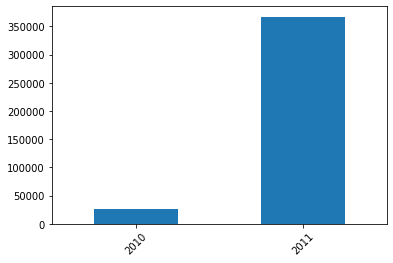

In [ ]:
desc_df.InvoiceDate.dt.year.value_counts(sort=False).plot(kind='bar', rot=45);

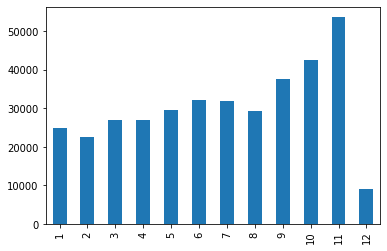

In [ ]:
desc_df[desc_df.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar');

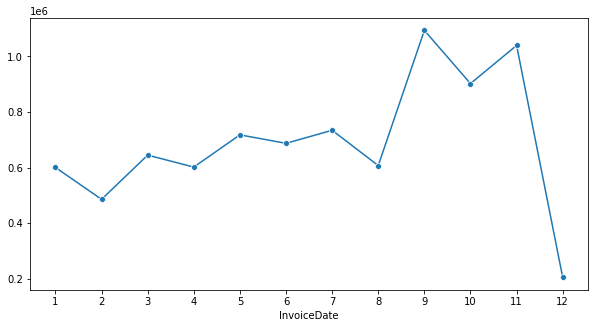

In [ ]:
monthly_gross = desc_df[desc_df.InvoiceDate.dt.year==2011].groupby(desc_df.InvoiceDate.dt.month).Total_cost.sum()
plt.figure(figsize=(10,5))
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index, marker='o');
plt.xticks(range(1,13))
plt.show();

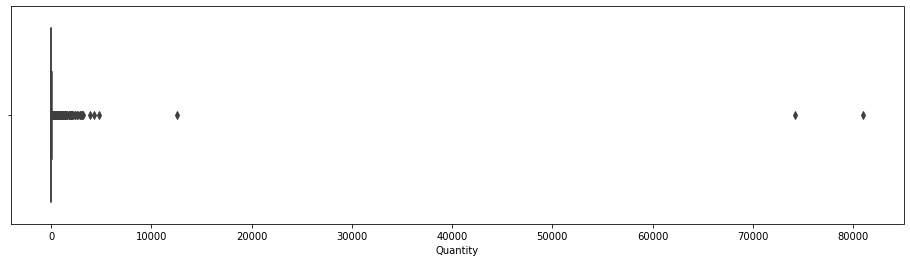

In [ ]:
plt.figure(figsize=(16,4))
sns.boxplot(x='Quantity', data=desc_df, orient='h');

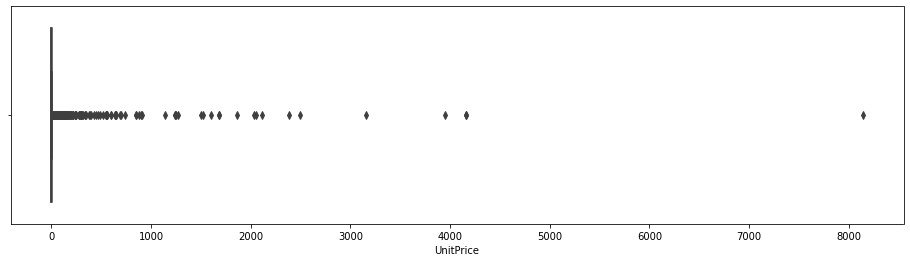

In [ ]:
plt.figure(figsize=(16,4))
sns.boxplot(x='UnitPrice', data=desc_df, orient='h');

In [ ]:
desc_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34


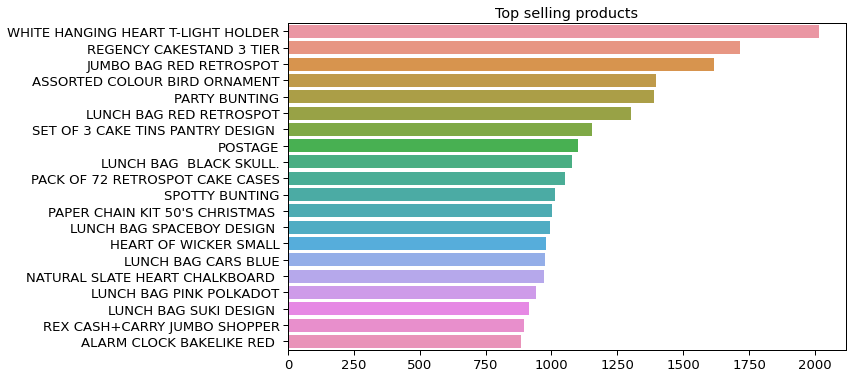

In [ ]:
#visualising the top selling products
top_products = desc_df['Description'].value_counts()[:20]
plt.figure(figsize=(10,6))
sns.set_context("paper", font_scale=1.5)
sns.barplot(y = top_products.index,
            x = top_products.values)
plt.title("Top selling products")
plt.show();



> Cohort Analysis



A cohort is a group of subjects who share a defining characteristic. We can observe how a cohort behaves across time and compare it to other cohorts.



1.   Define Cohorts and create Transaction
2.   Calculate offset for each Transaction
3.   Calculate Retention Rate
4.   Average Spend and Average quantity per Cohort



In [ ]:
cohort = rfm_train.copy()

In [ ]:
def get_month(x):
    return dt.datetime(x.year,x.month,1) 

cohort['InvoiceMonth'] = cohort['InvoiceDate'].apply(get_month) 

grouping = cohort.groupby('CustomerID')['InvoiceMonth'] 

cohort['CohortMonth'] = grouping.transform('min')

In [ ]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

In [ ]:
invoice_year, invoice_month = get_date_int(cohort,'InvoiceMonth')

cohort_year, cohort_month = get_date_int(cohort,'CohortMonth')

In [ ]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Extract the difference in months from all previous values
cohort['CohortIndex'] = years_diff * 12 + months_diff + 1

In [ ]:
cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,2010-01-01,2010-01-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,2010-01-01,2010-01-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,2010-01-01,2010-01-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,2010-01-01,2010-01-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,2010-01-01,2010-01-01,1


In [ ]:
grouping = cohort.groupby(['CohortMonth', 'CohortIndex'])

In [ ]:
# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

# Create a pivot 
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)*100

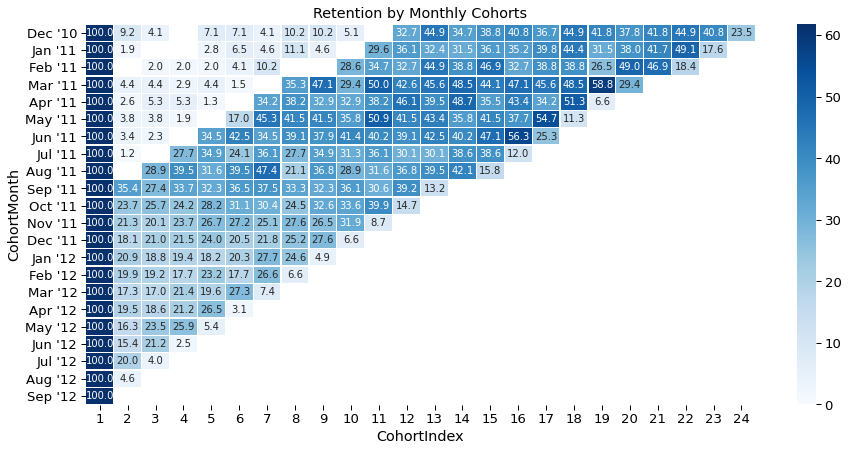

In [ ]:
month_list = ["Dec '10", "Jan '11", "Feb '11", "Mar '11", "Apr '11",\
              "May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11", \
              "Oct '11", "Nov '11", "Dec '11", "Jan '12", "Feb '12", \
              "Mar '12", "Apr '12", "May '12", "Jun '12", "Jul '12", \
              "Aug '12", "Sep '12",]

# Initialize inches plot figure
plt.figure(figsize=(15,7))

# Add a title
plt.title('Retention by Monthly Cohorts')

# Create the heatmap
sns.heatmap(data=retention,
            annot = True,
            cmap = "Blues",
            vmin = 0.0,
#             vmax = 0.5,
            vmax = list(retention.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)

plt.show();

In [ ]:
grouping = cohort.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')
average_price.round(1)
average_price.index = average_price.index.date


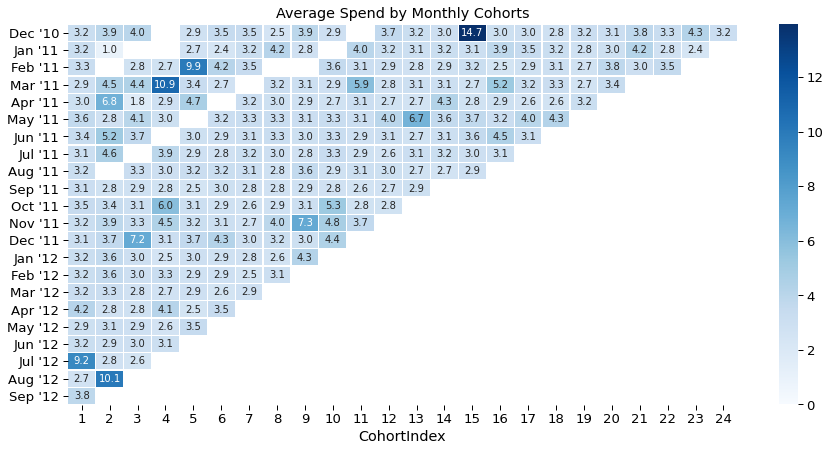

In [ ]:
plt.figure(figsize=(15, 7))

# Add a title
plt.title('Average Spend by Monthly Cohorts')

# Create the heatmap
sns.heatmap(data = average_price,
            annot=True,
            vmin = 0.0,
#             vmax =20,
            cmap='Blues',
            vmax = list(average_price.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)
plt.show();

In [ ]:
grouping = cohort.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the Quantity column
cohort_data = grouping['Quantity'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
# average_quantity.round(1)
# average_quantity.index = average_quantity.index.date

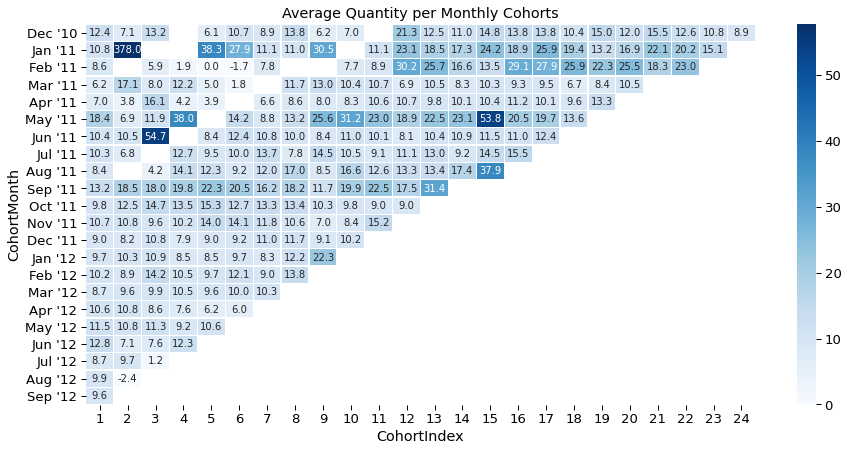

In [ ]:
# Initialize plot figure
plt.figure(figsize=(15, 7))

# Add a title
plt.title('Average Quantity per Monthly Cohorts')

# Create the heatmap
sns.heatmap(data = average_quantity,
            annot=True,
            vmin = 0.0,
            cmap='Blues',
            vmax = list(average_quantity.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)
plt.show();



> RFM Analysis



RFM analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

1.   Recency (R): Time since last purchase
2.   Frequency (F): Total number of purchases
3.   Monetary (M): Total purchase value

In [ ]:
rfm_train['InvoiceDate'].max()

Timestamp('2011-12-10 17:19:00')

In [ ]:
current_date = dt.date(2011,12,9)

In [ ]:
rfm_train['Purchase_Date'] = rfm_train.InvoiceDate.dt.date

In [ ]:
recency = rfm_train.groupby('CustomerID')['Purchase_Date'].max().reset_index()

In [ ]:
recency = recency.assign(Current_Date = current_date)

In [ ]:
recency['Recency'] = recency.Purchase_Date.apply(lambda x: (current_date - x).days)

In [ ]:
recency.head()

,CustomerID,Purchase_Date,Current_Date,Recency
0,12346,2011-01-18,2011-12-09,325
1,12347,2011-10-31,2011-12-09,39
2,12348,2011-09-25,2011-12-09,75
3,12349,2011-11-21,2011-12-09,18
4,12350,2011-02-02,2011-12-09,310


In [ ]:
recency.drop(['Purchase_Date','Current_Date'], axis=1, inplace=True)

In [ ]:
frequency = rfm_train.groupby('CustomerID').InvoiceNo.nunique().reset_index().rename(columns={'InvoiceNo':'Frequency'})

In [ ]:
frequency.head()

,CustomerID,Frequency
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [ ]:
rfm_train['Total_cost'] = rfm_train.Quantity * rfm_train.UnitPrice

In [ ]:
monetary = rfm_train.groupby('CustomerID').Total_cost.sum().reset_index().rename(columns={'Total_cost':'Monetary'})

In [ ]:
monetary.head()

,CustomerID,Monetary
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [ ]:
temp_ = recency.merge(frequency, on='CustomerID')
rfm_table = temp_.merge(monetary, on='CustomerID')

In [ ]:
rfm_table.set_index('CustomerID',inplace=True)
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,2,0.00
12347,39,7,4310.00
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.40


In [ ]:
# Fetch the records corresponding to the first customer id in above table
rfm_train[rfm_train.CustomerID == rfm_table.index[0]]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Purchase_Date,Total_cost
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,2011-01-18,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,2011-01-18,-77183.6


In [ ]:
(current_date - rfm_train[rfm_train.CustomerID == rfm_table.index[0]].iloc[0].Purchase_Date).days == rfm_table.iloc[0,0]

True

In [ ]:
quantiles = rfm_table.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,19.0,1.0,291.795
0.50,56.0,3.0,644.070
0.75,151.0,5.0,1608.335


In [ ]:
quantiles=quantiles.to_dict()
quantiles

{'Frequency': {0.25: 1.0, 0.5: 3.0, 0.75: 5.0},
 'Monetary': {0.25: 291.79499999999996,
  0.5: 644.0700000000002,
  0.75: 1608.335},
 'Recency': {0.25: 19.0, 0.5: 56.0, 0.75: 151.0}}

In [ ]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [ ]:
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [ ]:
rfm_segment = rfm_table.copy()
rfm_segment['R_Quartile'] = rfm_segment['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segment['F_Quartile'] = rfm_segment['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segment['M_Quartile'] = rfm_segment['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [ ]:
rfm_segment.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12346,325,2,0.00,1,2,1
12347,39,7,4310.00,3,4,4
12348,75,4,1797.24,2,3,4
12349,18,1,1757.55,4,1,4
12350,310,1,334.40,1,1,2


In [ ]:
rfm_segment['RFMScore'] = rfm_segment.R_Quartile.map(str) \
                            + rfm_segment.F_Quartile.map(str) \
                            + rfm_segment.M_Quartile.map(str)
rfm_segment.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
12346,325,2,0.00,1,2,1,121
12347,39,7,4310.00,3,4,4,344
12348,75,4,1797.24,2,3,4,234
12349,18,1,1757.55,4,1,4,414
12350,310,1,334.40,1,1,2,112


In [ ]:
rfm_segment.reset_index(inplace=True)

In [ ]:
segment_dict = {
    'Best Customers':'444',      # Highest frequency as well as monetary value with least recency
    'Loyal Customers':'344',     # High frequency as well as monetary value with good recency
    'Big Spenders':'334',        # High monetary value but good recency and frequency values
    'Almost Lost':'244',         # Customer's shopping less often now who used to shop a lot
    'Lost Customers':'144',      # Customer's shopped long ago who used to shop a lot.
    'Recent Customers':'443',    # Customer's who recently started shopping a lot but with less monetary value
    'Lost Cheap Customers':'122' # Customer's shopped long ago but with less frequency and monetary value
}

In [ ]:
# Swap the key and value of dictionary
dict_segment = dict(zip(segment_dict.values(),segment_dict.keys()))

In [ ]:
rfm_segment['Segment'] = rfm_segment.RFMScore.map(lambda x: dict_segment.get(x))

In [ ]:
rfm_segment.Segment.fillna('others', inplace=True)

In [ ]:
rfm_segment.sample(10)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
1433,14280,196,1,134.04,1,1,1,111,others
1856,14860,19,2,168.62,4,2,1,421,others
3587,17217,234,1,113.50,1,1,1,111,others
3101,16542,53,1,119.62,3,1,1,311,others
1179,13931,85,3,1230.93,2,2,3,223,others
426,12883,24,4,703.47,3,3,3,333,others
3004,16407,12,10,2079.68,4,4,4,444,Best Customers
2847,16191,0,25,4913.32,4,4,4,444,Best Customers
2617,15874,127,9,4330.67,2,4,4,244,Almost Lost
1895,14911,-1,248,132458.73,4,4,4,444,Best Customers


In [ ]:
rfm_segment[rfm_segment.RFMScore=='444'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
1703,14646,1,77,279489.02,4,4,4,444,Best Customers
4233,18102,11,62,256438.49,4,4,4,444,Best Customers
3758,17450,2,55,187322.17,4,4,4,444,Best Customers
1895,14911,-1,248,132458.73,4,4,4,444,Best Customers
1345,14156,-1,66,113214.59,4,4,4,444,Best Customers


In [ ]:
rfm_segment[rfm_segment.RFMScore=='334'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
2522,15749,38,4,21535.90,3,3,4,334,Big Spenders
2923,16303,25,4,5305.83,3,3,4,334,Big Spenders
2897,16258,45,5,5203.51,3,3,4,334,Big Spenders
70,12432,42,5,5059.32,3,3,4,334,Big Spenders
2548,15786,43,5,4821.00,3,3,4,334,Big Spenders


In [ ]:
rfm_segment[rfm_segment.RFMScore=='244'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
2945,16333,123,22,26626.80,2,4,4,244,Almost Lost
3973,17735,108,19,13110.02,2,4,4,244,Almost Lost
50,12409,64,7,11056.93,2,4,4,244,Almost Lost
3854,17581,65,31,10716.31,2,4,4,244,Almost Lost
1794,14769,77,10,10383.83,2,4,4,244,Almost Lost


In [ ]:
rfm_segment[rfm_segment.RFMScore=='122'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
808,13417,205,2,640.83,1,2,2,122,Lost Cheap Customers
1578,14481,164,2,636.51,1,2,2,122,Lost Cheap Customers
2246,15384,169,3,635.76,1,2,2,122,Lost Cheap Customers
1391,14220,188,2,632.40,1,2,2,122,Lost Cheap Customers
2142,15244,213,2,631.57,1,2,2,122,Lost Cheap Customers


In [ ]:
rfm_segment[rfm_segment.RFMScore=='344'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
55,12415,24,26,123725.45,3,4,4,344,Loyal Customers
1005,13694,25,60,62690.54,3,4,4,344,Loyal Customers
2722,16029,29,76,53168.69,3,4,4,344,Loyal Customers
2537,15769,40,29,51823.72,3,4,4,344,Loyal Customers
1447,14298,52,45,50862.44,3,4,4,344,Loyal Customers


In [ ]:
rfm_segment[rfm_segment.RFMScore=='244'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
2945,16333,123,22,26626.80,2,4,4,244,Almost Lost
3973,17735,108,19,13110.02,2,4,4,244,Almost Lost
50,12409,64,7,11056.93,2,4,4,244,Almost Lost
3854,17581,65,31,10716.31,2,4,4,244,Almost Lost
1794,14769,77,10,10383.83,2,4,4,244,Almost Lost




> K-means Clustering



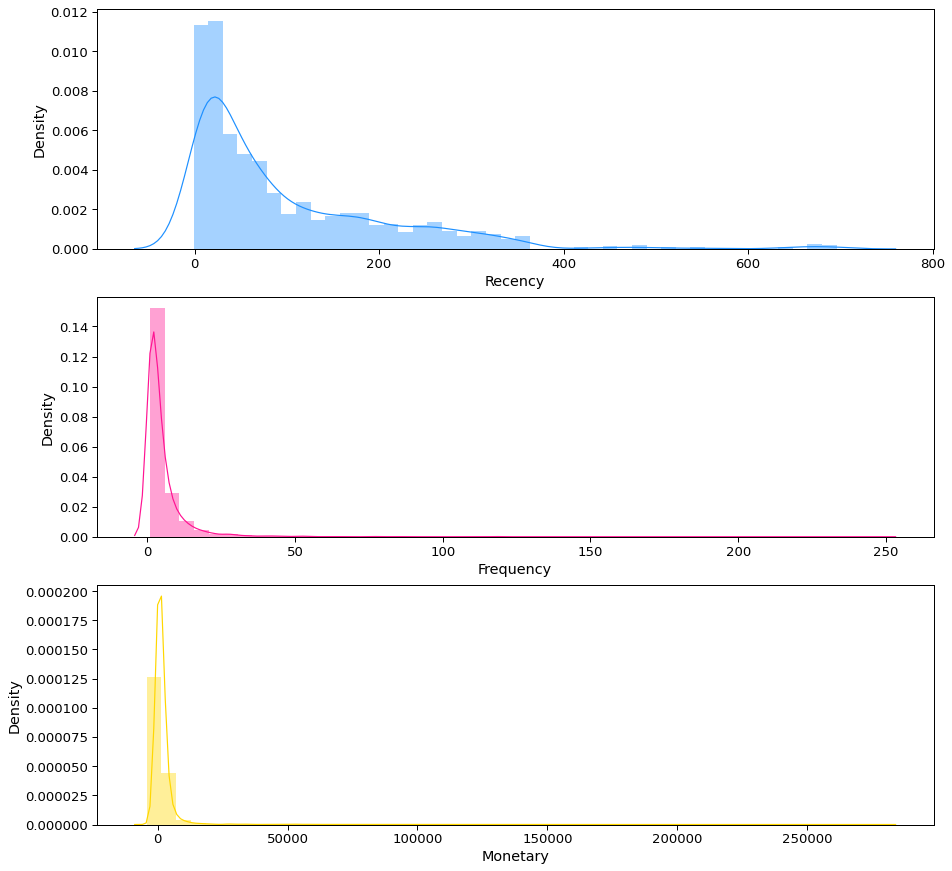

In [ ]:
#visualising distribution of RFM table
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
sns.distplot(rfm_table.Recency , color="dodgerblue", ax=axes[0], axlabel='Recency')
sns.distplot(rfm_table.Frequency , color="deeppink", ax=axes[1], axlabel='Frequency')
sns.distplot(rfm_table.Monetary , color="gold", ax=axes[2], axlabel='Monetary')
# plt.xlim(50,75);
plt.show();

In [ ]:
rfm_table.describe()

,Recency,Frequency,Monetary
count,4372.000000,4372.000000,4372.000000
mean,99.987420,5.075480,1893.531433
std,113.931649,9.338754,8218.696204
min,-1.000000,1.000000,-4287.630000
25%,19.000000,1.000000,291.795000
50%,56.000000,3.000000,644.070000
75%,151.000000,5.000000,1608.335000
max,696.000000,248.000000,279489.020000


In [ ]:
rfm_table_scaled = rfm_table.copy()

# Shift all values in the column by adding absolute of minimum value to each value, thereby making each value positive.
rfm_table_scaled.Monetary = rfm_table_scaled.Monetary + abs(rfm_table_scaled.Monetary.min()) + 1
rfm_table_scaled.Recency = rfm_table_scaled.Recency + abs(rfm_table_scaled.Recency.min()) + 1

# Check the summary of new values
rfm_table_scaled.describe()

,Recency,Frequency,Monetary
count,4372.000000,4372.000000,4372.000000
mean,101.987420,5.075480,6182.161433
std,113.931649,9.338754,8218.696204
min,1.000000,1.000000,1.000000
25%,21.000000,1.000000,4580.425000
50%,58.000000,3.000000,4932.700000
75%,153.000000,5.000000,5896.965000
max,698.000000,248.000000,283777.650000


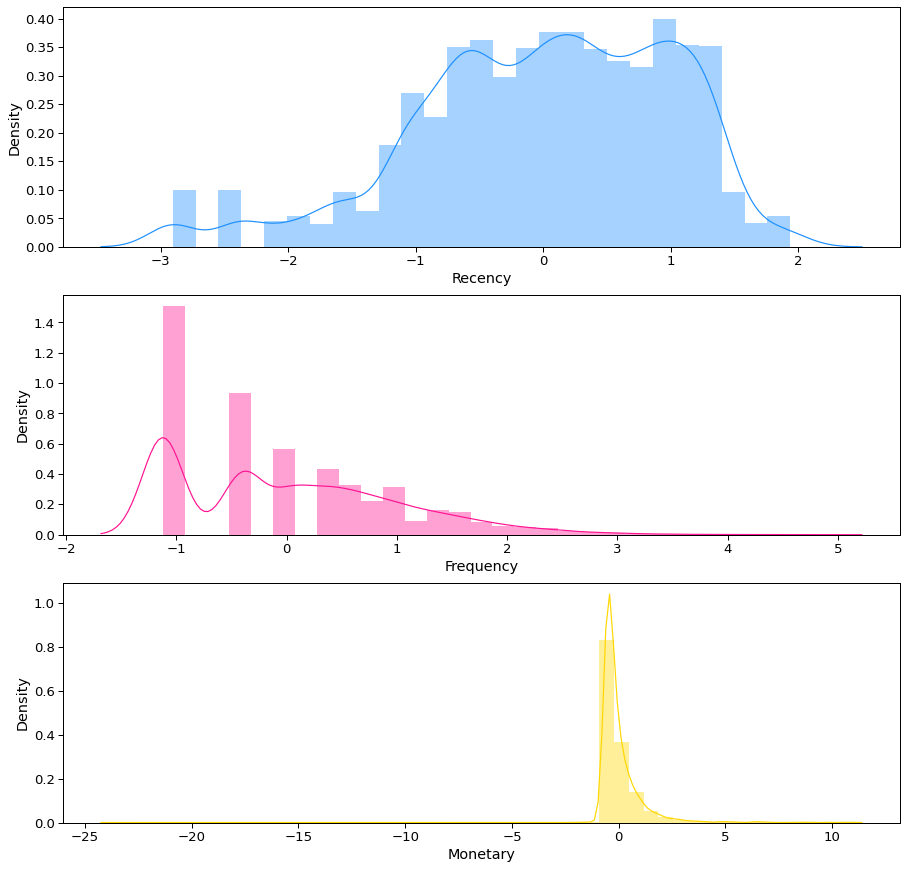

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Taking log first because normalization forces data for negative values
log_df = np.log(rfm_table_scaled)

# Normalize the data for uniform averages and means in the distribution.
scaler = StandardScaler()
normal_df = scaler.fit_transform(log_df)
normal_df = pd.DataFrame(data=normal_df, index=rfm_table.index, columns=rfm_table.columns)

fig, axes = plt.subplots(3, 1, figsize=(15, 15))
sns.distplot(normal_df.Recency , color="dodgerblue", ax=axes[0], axlabel='Recency')
sns.distplot(normal_df.Frequency , color="deeppink", ax=axes[1], axlabel='Frequency')
sns.distplot(normal_df.Monetary , color="gold", ax=axes[2], axlabel='Monetary')
plt.show()

Elbow plot used to find the optimised value of k

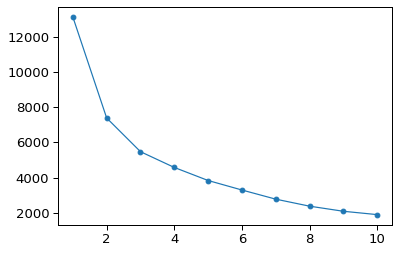

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(normal_df)
    wcss.append(kmeans.inertia_)

# plot elbow graph
plt.plot(range(1,11),wcss,marker='o');

Silhouette score for number of cluster(s) 2: 0.43794379408247563
Silhouette score for number of cluster(s) 3: 0.3990630883592966
Silhouette score for number of cluster(s) 4: 0.3506511720364267
Silhouette score for number of cluster(s) 5: 0.359137587682628
Silhouette score for number of cluster(s) 6: 0.3602383449574713
Silhouette score for number of cluster(s) 7: 0.3493446196344483
Silhouette score for number of cluster(s) 8: 0.35394538300108486
Silhouette score for number of cluster(s) 9: 0.3511219477956941
Silhouette score for number of cluster(s) 10: 0.34965175400360554
Silhouette score for number of cluster(s) 11: 0.3431961289200369


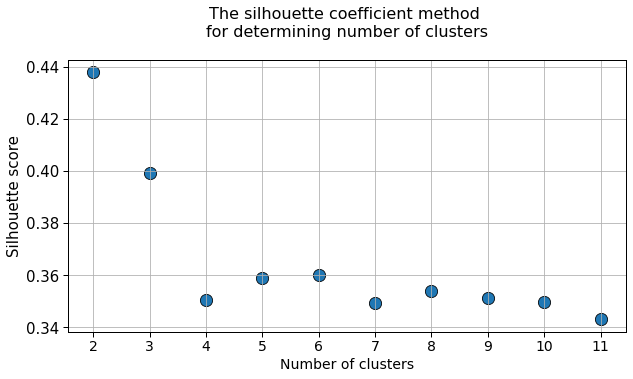

In [ ]:
from sklearn.metrics import silhouette_score
wcss_silhouette = []
for i in range(2,12):
    km = KMeans(n_clusters=i, random_state=0,init='k-means++').fit(normal_df)
    preds = km.predict(normal_df)    
    silhouette = silhouette_score(normal_df,preds)
    wcss_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

plt.figure(figsize=(10,5))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=wcss_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=1, init='k-means++')
kmeans.fit(normal_df)
cluster_labels = kmeans.labels_

In [ ]:
kmeans


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [ ]:
print(f"Shape of cluster label array is {cluster_labels.shape}")
print(f"Shape of RFM segment dataframe is {rfm_segment.shape}")

Shape of cluster label array is (4372,)
Shape of RFM segment dataframe is (4372, 9)


In [ ]:
Cluster_table = rfm_segment.assign(Cluster = cluster_labels)

In [ ]:
Cluster_table.Cluster.value_counts()

1    1770
3    1610
2     868
0     124
Name: Cluster, dtype: int64

In [ ]:
Cluster_table.sample(10)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
3523,17118,317,1,157.02,1,1,1,111,others,1
2676,15970,98,1,314.10,2,1,2,212,others,1
1549,14442,119,5,1544.62,2,3,3,233,others,3
1918,14951,79,1,311.69,2,1,2,212,others,1
2208,15332,484,4,1661.06,1,3,4,134,others,1
1634,14548,2,2,652.80,4,2,3,423,others,3
279,12684,24,7,2283.63,3,4,4,344,Loyal Customers,2
316,12728,38,4,836.33,3,3,3,333,others,3
3821,17535,250,1,164.40,1,1,1,111,others,1
4135,17962,142,1,102.41,2,1,1,211,others,1


In [ ]:
Cluster_table[Cluster_table.Cluster == 3].sample(5)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
716,13285,23,4,2709.12,3,3,4,334,Big Spenders,3
397,12843,65,9,1680.76,2,4,4,244,Almost Lost,3
1890,14904,25,2,1025.44,3,2,3,323,others,3
1530,14418,25,3,1937.25,3,2,4,324,others,3
2654,15935,5,2,416.86,4,2,2,422,others,3


In [ ]:
Cluster_table[Cluster_table.Cluster == 2].sample(5)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
2425,15622,43,16,3224.53,3,4,4,344,Loyal Customers,2
4167,18008,35,9,2116.19,3,4,4,344,Loyal Customers,2
1358,14175,29,7,3108.06,3,4,4,344,Loyal Customers,2
3668,17337,4,7,1897.51,4,4,4,444,Best Customers,2
1367,14189,9,24,4604.31,4,4,4,444,Best Customers,2


In [ ]:
Cluster_table[Cluster_table.Cluster == 1].sample(5)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
2834,16178,138,1,197.90,2,1,1,211,others,1
3943,17698,260,1,154.95,1,1,1,111,others,1
4115,17935,138,2,145.79,2,2,1,221,others,1
2550,15789,358,1,351.30,1,1,2,112,others,1
2393,15579,302,2,327.60,1,2,2,122,Lost Cheap Customers,1


In [ ]:
Cluster_table[Cluster_table.Cluster == 0].sample(5)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
2537,15769,40,29,51823.72,3,4,4,344,Loyal Customers,0
1206,13969,16,20,8956.92,4,4,4,444,Best Customers,0
100,12471,-1,49,18705.52,4,4,4,444,Best Customers,0
756,13340,45,7,10736.48,3,4,4,344,Loyal Customers,0
1720,14667,10,27,9165.04,4,4,4,444,Best Customers,0


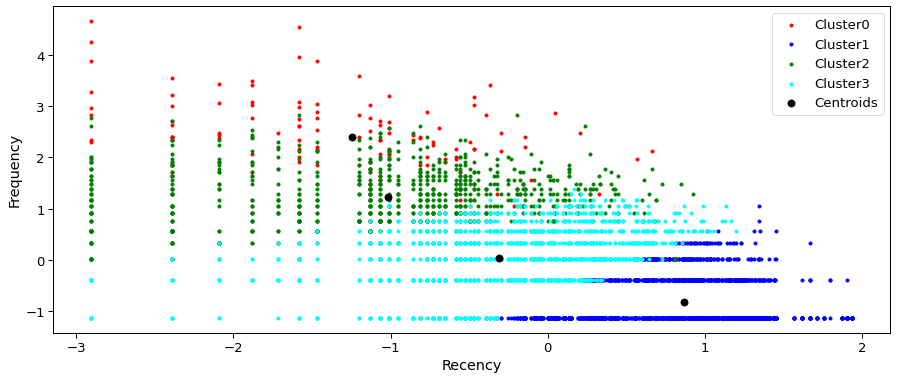

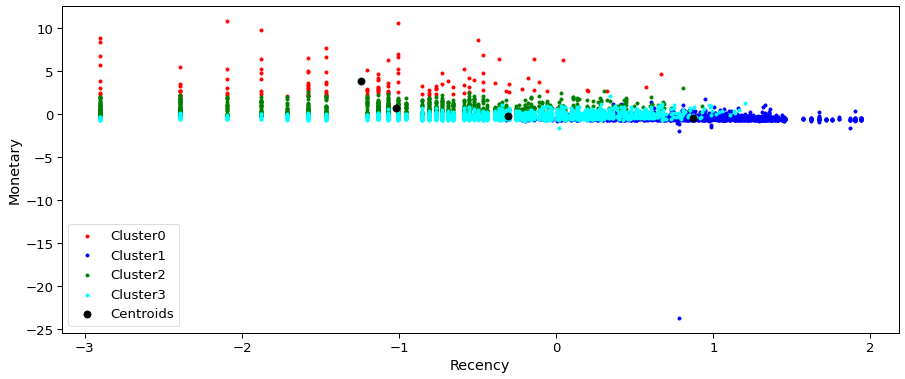

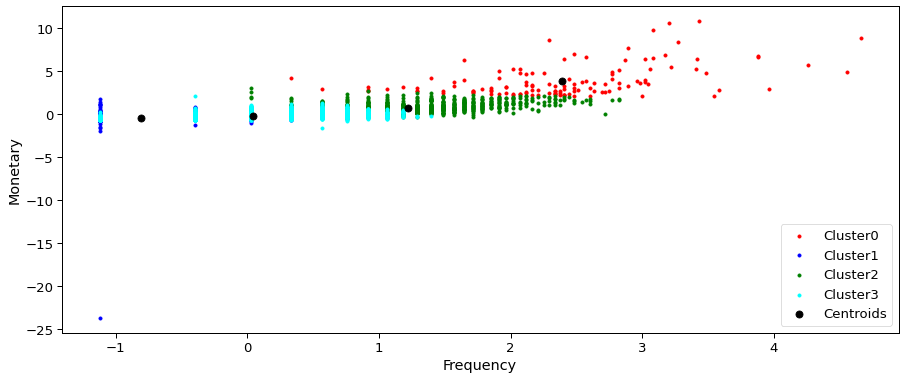

In [ ]:
# Plotting two dimesional plots of each attributes respectively.
X = normal_df.iloc[:,0:3].values
count=X.shape[1]
for i in range(0,count):
    for j in range(i+1,count):
        plt.figure(figsize=(15,6));
        plt.scatter(X[cluster_labels == 0, i], X[cluster_labels == 0, j], s = 10, c = 'red', label = 'Cluster0')
        plt.scatter(X[cluster_labels == 1, i], X[cluster_labels == 1, j], s = 10, c = 'blue', label = 'Cluster1')
        plt.scatter(X[cluster_labels == 2, i], X[cluster_labels == 2, j], s = 10, c = 'green', label = 'Cluster2')
        plt.scatter(X[cluster_labels == 3, i], X[cluster_labels == 3, j], s = 10, c = 'cyan', label = 'Cluster3')
        plt.scatter(kmeans.cluster_centers_[:,i], kmeans.cluster_centers_[:,j], s = 50, c = 'black', label = 'Centroids')
        plt.xlabel(normal_df.columns[i])
        plt.ylabel(normal_df.columns[j])
        plt.legend()        
        plt.show();

In [ ]:
normal_df = normal_df.assign(Cluster = cluster_labels)

# Melt normalized dataframe into long form to have all metric in same column
normal_melt = pd.melt(normal_df.reset_index(),
                      id_vars=['CustomerID','Cluster'],
                      value_vars=['Recency', 'Frequency', 'Monetary'],
                      var_name='Metric',
                      value_name='Value')
normal_melt.head()

,CustomerID,Cluster,Metric,Value
0,12346,1,Recency,1.376105
1,12347,2,Recency,-0.159463
2,12348,3,Recency,0.306618
3,12349,3,Recency,-0.690333
4,12350,1,Recency,1.341379


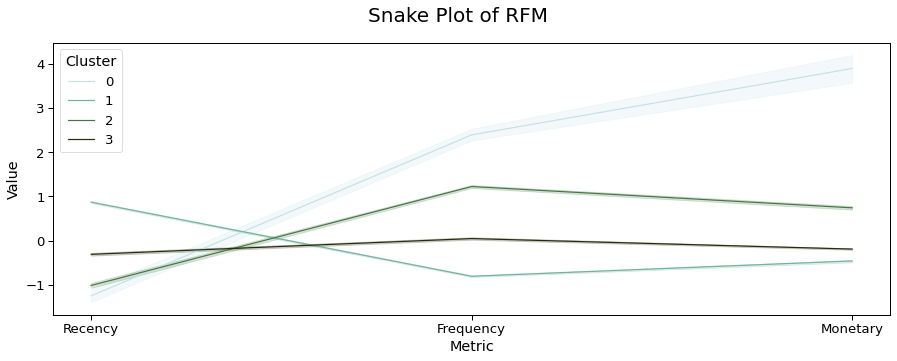

In [ ]:
plt.figure(figsize=(15,5))
palette = sns.color_palette("mako_r", 4)
sns.lineplot(x = 'Metric',
             y = 'Value',
             hue = 'Cluster',
             data = normal_melt,
             palette = "ch:4.4,.44")

plt.suptitle("Snake Plot of RFM",fontsize=20)
plt.show();

In [ ]:
rfm_table_cluster = rfm_table.assign(Cluster = cluster_labels)

# Average attributes for each cluster
cluster_avg = rfm_table_cluster.groupby(['Cluster']).mean() 

# Calculate the population average
population_avg = rfm_table.mean()

# Calculate relative importance of attributes by 
relative_imp = cluster_avg / population_avg - 1

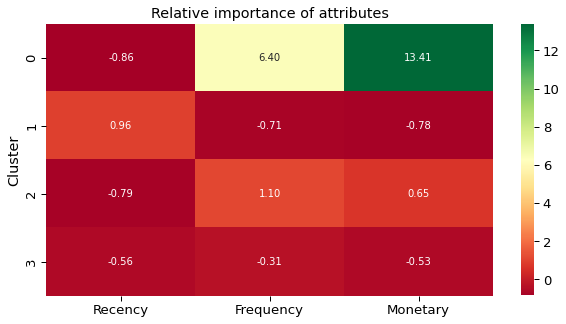

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show();